In [1]:
import torch
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from gtda.graphs import KNeighborsGraph
import itertools
import random
import math
import sys
import os


from importlib import reload
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.path.realpath('.'), '..'))
from preprocessor_final_data import Preprocessor
from preprocessor_final_data import draw_network
from preprocessor_final_data import get_adj_from_plot

from torch_geometric.nn import GCNConv

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv

import Model3
reload(Model3)
from Model3 import GraphConvolutionalNetwork
from Model3 import KroneckerDataset
from torch.utils.data import DataLoader, Subset, random_split, SequentialSampler


In [2]:
print("Gathering data...")
flow_dataset = "../data/daily_county2county_2019_01_01.csv"
epi_dataset = "../data_epi/epidemiology.csv"

Gathering data...


In [9]:
# THIS IS WITH THE NEW PREPROCESSOR FILE (PREPROCESSOR_FINAL_DATA.PY)
locations_data = "../final_data/locations_data_unique.npy"
epi_dataset = "../final_data/X_normalized.npy"

# GRAPH CONVOLUTIONAL NETWORK BASED ON KRONECKER GRAPH
import Model3
reload(Model3)
from Model3 import KroneckerDataset

# Define the model parameters
desired_num_params = 2000
input_horizon = 7   # test now with smaller input horizon
prediction_horizon = 1    # test now with smaller prediction horizon

data = KroneckerDataset(Preprocessor(flow_dataset, epi_dataset, locations_data, plottable=True), input_horizon, prediction_horizon)
dataset = data

# Created using indices from 0 to train_size.
train_dataset = Subset(data, range(0, math.floor(len(data) * 0.8)))

# Created using indices from train_size to train_size + test_size.
test_dataset = Subset(data, range(math.floor(len(data) * 0.8), len(data)))

# train_indices, test_indices = random_split(data, [0.8, 0.2])

# # generate subset based on indices
# train_split = Subset(data, train_indices)
# test_split = Subset(data, test_indices)

#train_sampler = SequentialSampler(data_source=train_dataset)
#test_sampler = SequentialSampler(data_source=test_dataset)

# # create batches
train_batches = DataLoader(train_dataset, batch_size=1, pin_memory=True, num_workers=0)
test_batches = DataLoader(test_dataset, batch_size=1, pin_memory=True, num_workers=0)

#next(iter(train_batches))

In [10]:
import Model3
reload(Model3)
from Model3 import GraphConvolutionalNetwork

#  Instantiate the model
model = GraphConvolutionalNetwork(desired_num_params, input_horizon, prediction_horizon, data.num_nodes)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", num_params)

# Define the loss function and optimizer
num_epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# shuffle the training data randomly
#random.shuffle(model.training_data)
#random.shuffle(model.testing_data)

Number of parameters: 2271


In [11]:
# TRAINING
train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    for batch in train_batches:
        output = model(batch) # needs to have shape [num_nodes_pred, num_features]
        
        loss = model.getLoss(output)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.8f}')

Epoch 1/10, Train Loss: 1.23985028
Epoch 2/10, Train Loss: 1.25226426
Epoch 3/10, Train Loss: 1.17026877
Epoch 4/10, Train Loss: 1.17532992
Epoch 5/10, Train Loss: 1.14030170
Epoch 6/10, Train Loss: 1.13831842
Epoch 7/10, Train Loss: 1.14096606
Epoch 8/10, Train Loss: 1.17081141
Epoch 9/10, Train Loss: 1.17620361
Epoch 10/10, Train Loss: 1.16000247


In [12]:
# Test the model
model.eval()
test_loss = 0.0
predictions = []
targets = []
with torch.no_grad():
    for data in test_batches:
        output = model(data) 

        loss = model.getLoss(output)
        test_loss += loss.item()
    test_loss /= len(test_batches)

# Compute metrics
print(f'Test Loss: {test_loss:.8f}')
print(model.target_graph_signal_matrix)


Test Loss: 1.18715069
tensor([[-0.3162],
        [-0.2454],
        [-0.0719],
        ...,
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])


32.534920756109095


/home/victor/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


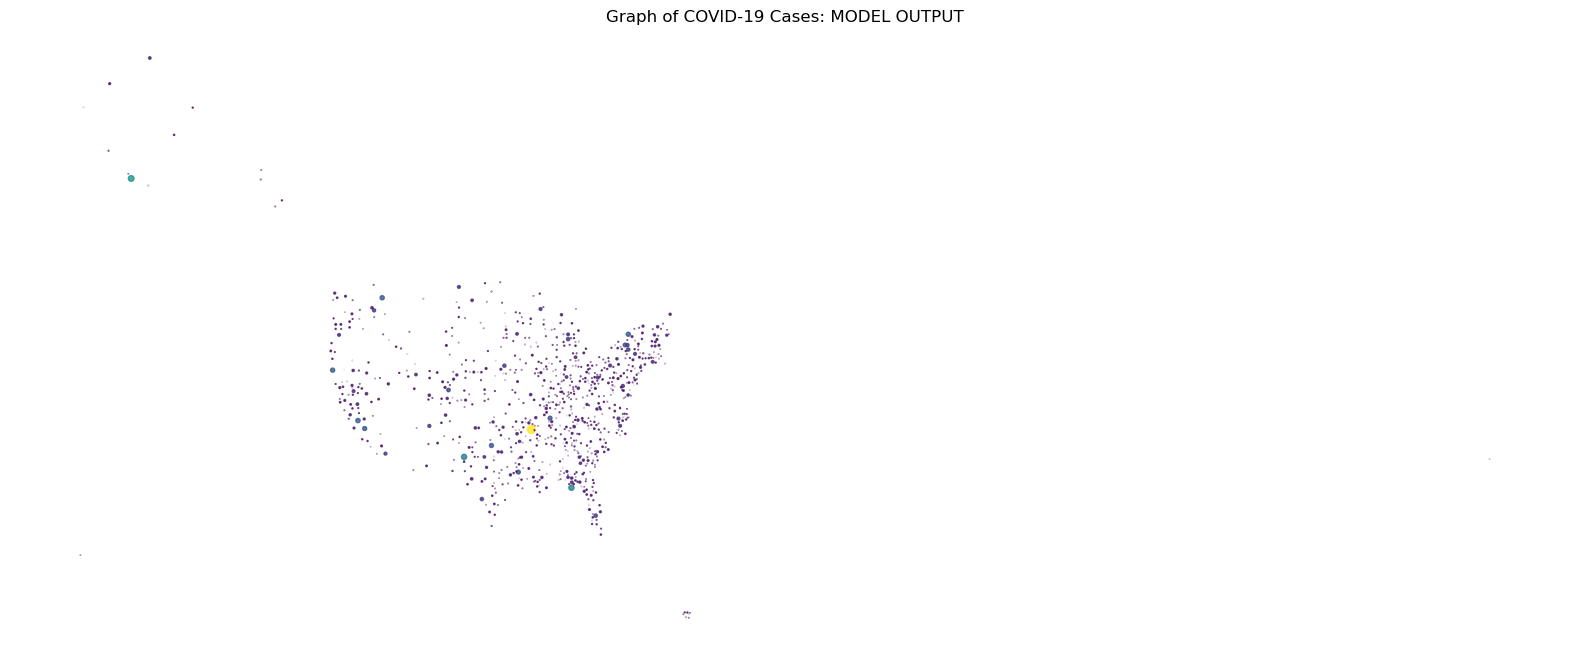

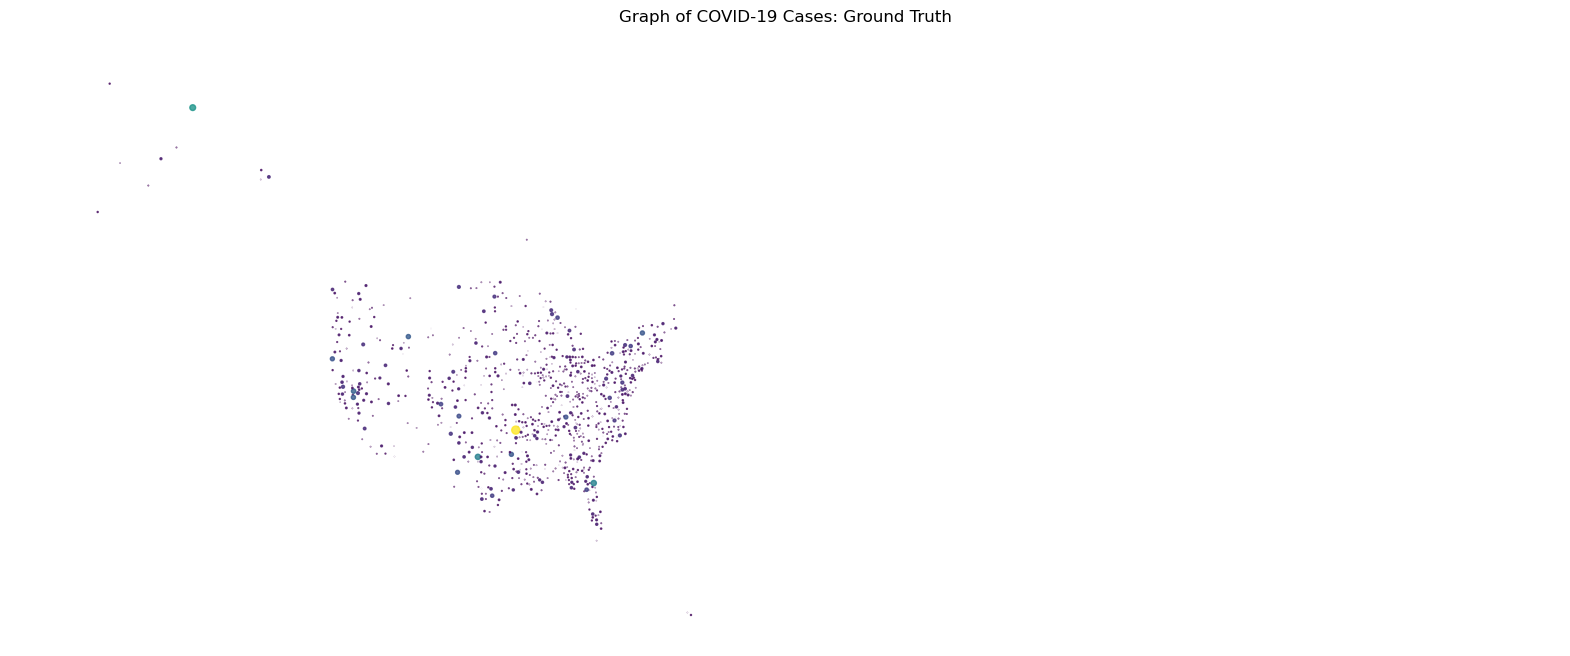

In [14]:
# plot the united states and have these values as the nodes

# get a list of the key values in train_graph_sig
geoid_list_train = list(dataset.train_graph_sig.keys())
target_graph_signal = next(iter(test_batches))[2] # model.testing_data[-1][2]
geoid_list_target = list(target_graph_signal.keys())

# make a dictionary where key is geoid_list entry and value is out entry
train_dict = {geoid_list_train[i]: output[i].item() for i in range(len(output))} # gets the {geoid : cum_confir}

target_dict = {i: target_graph_signal[i]['cumulative_confirmed'] for i in geoid_list_target}

# need to get the geographical information on where to put these nodes
# get the geographical information from the preprocessor, 'geoid_o', 'lat_o', 'lng_o' for all the geoids in train_dict
#print(graph_kronecker_whole_df)

# for each geoid_o which is a key in train_dict, get the lat_o and lng_o from the graph_kronecker_whole_df
# then plot the united states and put the values of train_dict as the node values (new_confirmed)
# then compare with the target_dict values

import networkx as nx
import matplotlib.pyplot as plt


# create model output plot
# Create an empty graph
G = nx.Graph()

# Add nodes with attributes
geoid_o = list(train_dict.keys())
print(dataset.graph_kronecker_whole_df[dataset.graph_kronecker_whole_df['geoid_o'] == list(train_dict.keys())[0]]['lat_o'].values[0])
lat_o = [dataset.graph_kronecker_whole_df[dataset.graph_kronecker_whole_df['geoid_o'] == key]['lat_o'].values[0] for key in train_dict.keys()]
lng_o = [dataset.graph_kronecker_whole_df[dataset.graph_kronecker_whole_df['geoid_o'] == key]['lng_o'].values[0] for key in train_dict.keys()]


# cumulative_confirmed = [train_dict[key] for key in train_dict.keys()] # train_dict[key] will return a dictionary not a value

cumulative_confirmed = []
# pull column 3 from graph_signal_matrix as cumulative_confirmed
for i in range(model.graph_signal_matrix.shape[0]):
    cumulative_confirmed.append(model.graph_signal_matrix[i])


for i in range(len(geoid_o)):
    G.add_node(geoid_o[i], cumulative_confirmed=cumulative_confirmed[i], lat=lat_o[i], lng=lng_o[i])

# Get node positions
pos = {node: (G.nodes[node]['lng'], G.nodes[node]['lat']) for node in G.nodes}

# Get node values
node_values = [G.nodes[node]['cumulative_confirmed'] for node in G.nodes]

# Plot the graph
plt.figure(figsize=(20, 8))
nx.draw_networkx(G, pos, node_color=node_values, cmap='viridis', node_size=node_values, alpha=0.8, with_labels=False)
# plt.colorbar(label='New Confirmed Cases')
plt.title('Graph of COVID-19 Cases: MODEL OUTPUT')
plt.axis('off')
plt.show()


########## create Ground truth plot
# Create an empty graph
G = nx.Graph()

# Add nodes with attributes
geoid_o = list(train_dict.keys())
lat_o = [dataset.graph_kronecker_whole_df[dataset.graph_kronecker_whole_df['geoid_o'] == key]['lat_o'].values[0] for key in train_dict.keys()]
lng_o = [dataset.graph_kronecker_whole_df[dataset.graph_kronecker_whole_df['geoid_o'] == key]['lng_o'].values[0] for key in train_dict.keys()]


# cumulative_confirmed = [train_dict[key] for key in train_dict.keys()] # train_dict[key] will return a dictionary not a value

cumulative_confirmed = []
# pull column 3 from graph_signal_matrix as cumulative_confirmed
for i in range(model.target_graph_signal_matrix.shape[0]):
    cumulative_confirmed.append(model.target_graph_signal_matrix[i])

for i in range(len(geoid_o)):
    G.add_node(geoid_o[i], cumulative_confirmed=cumulative_confirmed[i], lat=lat_o[i], lng=lng_o[i])

# Get node positions
pos = {node: (G.nodes[node]['lng'], G.nodes[node]['lat']) for node in G.nodes}

# Get node values
node_values = [G.nodes[node]['cumulative_confirmed'] for node in G.nodes]

# Plot the graph
plt.figure(figsize=(20, 8))
nx.draw_networkx(G, pos, node_color=node_values, cmap='viridis', node_size=node_values, alpha=0.8, with_labels=False)
# plt.colorbar(label='New Confirmed Cases')
plt.title('Graph of COVID-19 Cases: Ground Truth')
plt.axis('off')
plt.show()